# Zooplankton timeseries from the CESM-LE

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
inset_axes

<function mpl_toolkits.axes_grid1.inset_locator.inset_axes(parent_axes, width, height, loc='upper right', bbox_to_anchor=None, bbox_transform=None, axes_class=None, axes_kwargs=None, borderpad=0.5)>

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [3]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['zoo_prod_zint','diatC_zint','spC_zint','zooC_zint']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)


zoo_prod_zint
diatC_zint
spC_zint
zooC_zint
CPU times: user 237 ms, sys: 9.21 ms, total: 246 ms
Wall time: 568 ms


In [4]:
ds['mesozooC'] = ds.zooC_zint * (ds.diatC_zint/(ds.diatC_zint + ds.spC_zint))
ds['diat_frac'] = ds.diatC_zint/(ds.diatC_zint + ds.spC_zint)

variables = variables + ['mesozooC','diat_frac']

### Necessary plotting function

In [5]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### get pop grid

In [6]:
grid = pop_tools.get_grid('POP_gx1v6')

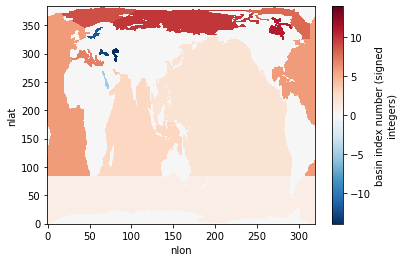

In [7]:
grid.REGION_MASK.plot()

In [8]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [9]:
ds = ds.where(grid.REGION_MASK>0)

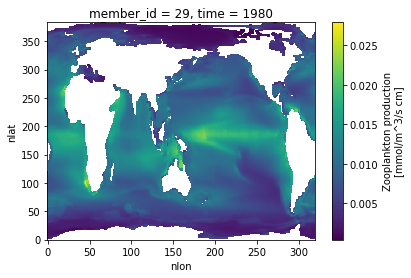

In [10]:
ds.zoo_prod_zint.isel(time=60,member_id=22).plot()

### Extract 1920s

In [11]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [12]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### Extract 1990s

In [13]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [14]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [15]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [16]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

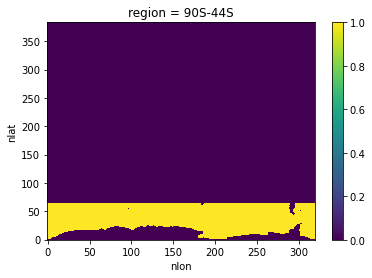

In [17]:
mask3d = pop_tools.region_mask_3d('POP_gx1v6', mask_name='lat-range-basin')
mask3d.isel(region=1).plot()

### get masks for making averages

In [18]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

### Make timeseries

In [19]:
variables

['zoo_prod_zint',
 'diatC_zint',
 'spC_zint',
 'zooC_zint',
 'mesozooC',
 'diat_frac']

### ACC

In [20]:
%%time

ts_ACC = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    print(v)
    masked = ds[v].where(ds_masks.ACC_mask==1.)
    ts_ACC[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()


zoo_prod_zint
diatC_zint
spC_zint
zooC_zint
mesozooC
diat_frac
CPU times: user 1min 2s, sys: 2min 13s, total: 3min 16s
Wall time: 3min 37s


### SIZ

In [21]:
%%time

ts_SIZ = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    print(v)
    masked = ds[v].where(ds_masks.SIZ_mask==1.)
    ts_SIZ[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

zoo_prod_zint
diatC_zint
spC_zint
zooC_zint
mesozooC
diat_frac
CPU times: user 1min 1s, sys: 2min 11s, total: 3min 12s
Wall time: 3min 20s


In [22]:
ts_ACC_ens_mean = ts_ACC.mean(dim='member_id')
ts_SIZ_ens_mean = ts_SIZ.mean(dim='member_id')

In [23]:
ens_mean_1920s = ds_1920s.mean(dim='member_id')

In [24]:
ens_mean_1990s = ds_1990s.mean(dim='member_id')

In [25]:
ens_mean_2090s = ds_2090s.mean(dim='member_id')

In [26]:
convert = 0.01 * 86400. # to convert from mmol/m3 cm/s to mmol/m2/d

### ACC zoo production

In [27]:
ts_ACC_ens_mean['zoo_prod_zint'].values

array([0.00589883, 0.00592495, 0.00593183, 0.00591005, 0.00596807,
       0.0059887 , 0.00597919, 0.00596261, 0.00594021, 0.00597013,
       0.00594657, 0.00594532, 0.0059359 , 0.00593945, 0.00595242,
       0.00601104, 0.00594547, 0.00593096, 0.00596545, 0.00598646,
       0.00599294, 0.00599944, 0.00600948, 0.00600673, 0.00597534,
       0.00597368, 0.00597482, 0.00592281, 0.00603866, 0.00597275,
       0.00593349, 0.0060093 , 0.00598874, 0.00596774, 0.00600193,
       0.00596032, 0.00593001, 0.00597967, 0.00602203, 0.00598967,
       0.00599733, 0.00599983, 0.00597041, 0.00591796, 0.00602567,
       0.00602901, 0.00596216, 0.00600493, 0.00599661, 0.00601347,
       0.00598872, 0.00602627, 0.0059961 , 0.00597459, 0.00601885,
       0.00599503, 0.00599714, 0.00604875, 0.00600597, 0.0060254 ,
       0.00602693, 0.00600555, 0.00594155, 0.00597133, 0.00605353,
       0.00603472, 0.00596744, 0.00598643, 0.00601278, 0.00604455,
       0.00597811, 0.00599574, 0.00600483, 0.00603821, 0.00602

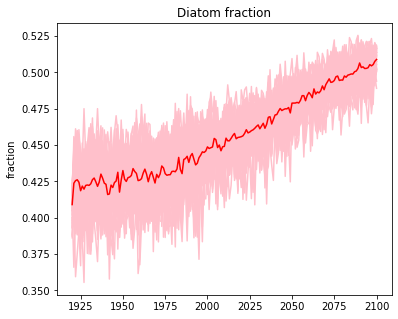

In [28]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
ax.set_title('Diatom fraction')
ax.set_ylabel('fraction')
#ax[0].set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax.plot(years, 
         ts_ACC['diat_frac'].isel(member_id=mem), 
         color='pink')

ax.plot(years, ts_ACC_ens_mean['diat_frac'], 
         color='red')

############


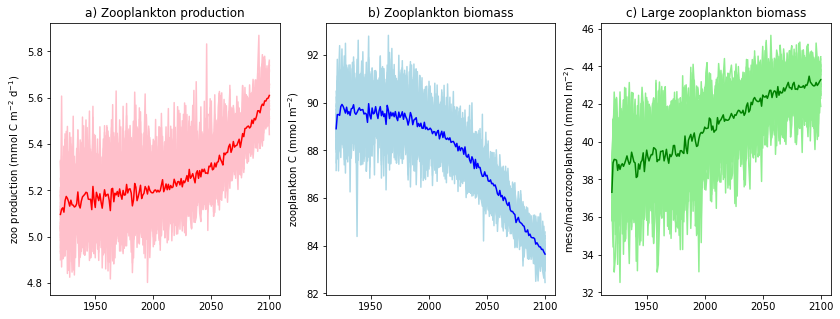

In [29]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,5))
ax[0].set_title('a) Zooplankton production')
ax[0].set_ylabel('zoo production (mmol C m$^{-2}$ d$^{-1}$)')
#ax[0].set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax[0].plot(years, 
         ts_ACC['zoo_prod_zint'].isel(member_id=mem) * convert, 
         color='pink')

ax[0].plot(years, ts_ACC_ens_mean['zoo_prod_zint'] * convert, 
         color='red')

############

ax[1].set_title('b) Zooplankton biomass')
ax[1].set_ylabel('zooplankton C (mmol m$^{-2}$)')
#ax[1].set_ylim(75,85)
for mem in np.arange(0,34,1):

    ax[1].plot(years, 
         ts_ACC['zooC_zint'].isel(member_id=mem), 
         color='lightblue')

ax[1].plot(years, ts_ACC_ens_mean['zooC_zint'], 
         color='blue');

############

ax[2].set_title('c) Large zooplankton biomass')
ax[2].set_ylabel('meso/macrozooplankton (mmol m$^{-2}$)')
#ax[2].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[2].plot(years, 
         ts_ACC['mesozooC'].isel(member_id=mem), 
         color='lightgreen')

ax[2].plot(years, ts_ACC_ens_mean['mesozooC'], 
         color='green')

#fig.savefig('/glade/work/kristenk/figs/zoo_ts_CESM-le.png', bbox_inches='tight', dpi=300, format='png');


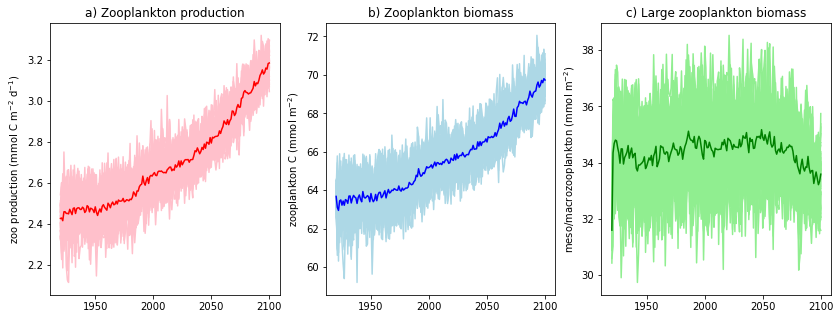

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,5))
ax[0].set_title('a) Zooplankton production')
ax[0].set_ylabel('zoo production (mmol C m$^{-2}$ d$^{-1}$)')
#ax[0].set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax[0].plot(years, 
         ts_SIZ['zoo_prod_zint'].isel(member_id=mem) * convert, 
         color='pink')

ax[0].plot(years, ts_SIZ_ens_mean['zoo_prod_zint'] * convert, 
         color='red')

############

ax[1].set_title('b) Zooplankton biomass')
ax[1].set_ylabel('zooplankton C (mmol m$^{-2}$)')
#ax[1].set_ylim(75,85)
for mem in np.arange(0,34,1):

    ax[1].plot(years, 
         ts_SIZ['zooC_zint'].isel(member_id=mem), 
         color='lightblue')

ax[1].plot(years, ts_SIZ_ens_mean['zooC_zint'], 
         color='blue');

############

ax[2].set_title('c) Large zooplankton biomass')
ax[2].set_ylabel('meso/macrozooplankton (mmol m$^{-2}$)')
#ax[2].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[2].plot(years, 
         ts_SIZ['mesozooC'].isel(member_id=mem), 
         color='lightgreen')

ax[2].plot(years, ts_SIZ_ens_mean['mesozooC'], 
         color='green')

#fig.savefig('/glade/work/kristenk/figs/zoo_ts_CESM-le.png', bbox_inches='tight', dpi=300, format='png');


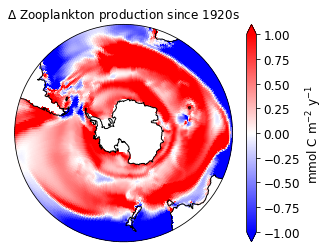

In [31]:
fig = plt.figure(figsize=(5,4))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats,  ens_mean_2090s['zoo_prod_zint'] * convert- ens_mean_1920s['zoo_prod_zint'] * convert)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\Delta}$ Zooplankton production since 1920s')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.pcolormesh(lon,lat,field, vmin=-1,vmax=1,
                     transform=ccrs.PlateCarree(),cmap='bwr')

ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(cf, ax=ax,extend='both',label='mmol C m$^{-2}$ y$^{-1}$')
cbar1.set_label(label='mmol C m$^{-2}$ y$^{-1}$', fontsize='12')
cbar1.ax.tick_params(labelsize=12) 

#fig.savefig('/glade/work/kristenk/figs/zoo_prod_change_map.png', bbox_inches='tight', dpi=300, format='png');


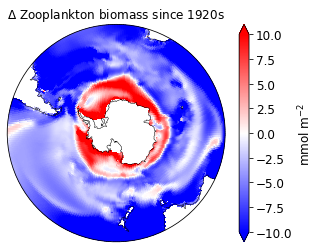

In [32]:
fig = plt.figure(figsize=(5,4))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats,  (ens_mean_2090s['zooC_zint']- ens_mean_1920s['zooC_zint']))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\Delta}$ Zooplankton biomass since 1920s')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.pcolormesh(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr', vmin=-10, vmax=10)

ax.coastlines('110m',linewidth=0.5)

cbar1 = fig.colorbar(cf, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$', fontsize='12')
cbar1.ax.tick_params(labelsize=12) 

#fig.savefig('/glade/work/kristenk/figs/zoo_biomass_change_map.png', bbox_inches='tight', dpi=300, format='png');


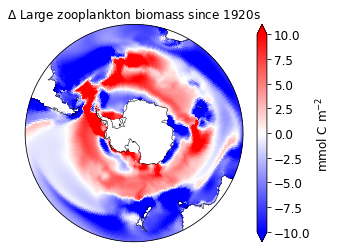

In [33]:
fig = plt.figure(figsize=(5,4))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats,  (ens_mean_2090s['mesozooC']- ens_mean_1920s['mesozooC']))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\Delta}$ Large zooplankton biomass since 1920s')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.pcolormesh(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr', vmin=-10, vmax=10)

ax.coastlines('110m',linewidth=0.5)

cbar1 = fig.colorbar(cf, ax=ax,extend='both',label='mmol C m$^{-2}$')
cbar1.set_label(label='mmol C m$^{-2}$', fontsize='12')
cbar1.ax.tick_params(labelsize=12) 

#fig.savefig('/glade/work/kristenk/figs/large_zoo_change_map.png', bbox_inches='tight', dpi=300, format='png');


In [34]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

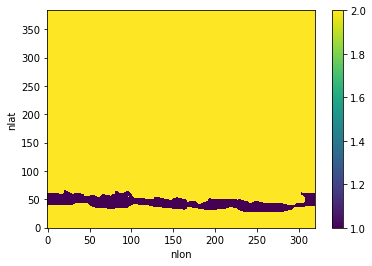

In [35]:
outside=np.full((384, 320), 2)

inside = ds_masks.ACC_mask.where(ds_masks.ACC_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

ACC=xr.DataArray(outside)
ACC=ACC.rename({'dim_0':'nlat'})
ACC=ACC.rename({'dim_1':'nlon'})
ACC.plot()

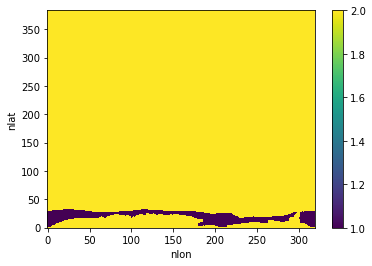

In [36]:
outside=np.full((384, 320), 2)

inside = ds_masks.SIZ_mask.where(ds_masks.SIZ_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

SIZ=xr.DataArray(outside)
SIZ=SIZ.rename({'dim_0':'nlat'})
SIZ=SIZ.rename({'dim_1':'nlon'})
SIZ.plot()

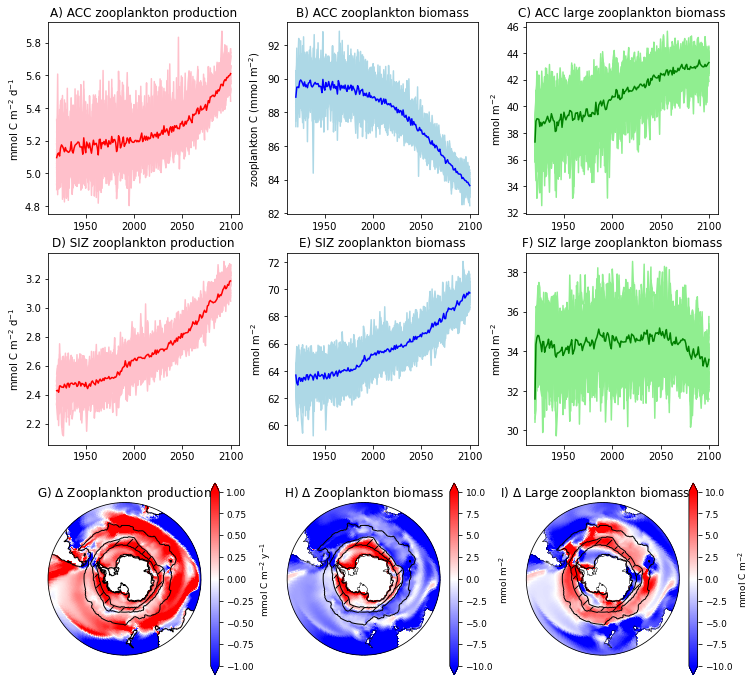

In [38]:
fig = plt.figure(figsize=(12,12))

########################################################## ACC line plots

ax = fig.add_subplot(3,3,1)
ax.set_title('A) ACC zooplankton production')
ax.set_ylabel('mmol C m$^{-2}$ d$^{-1}$')
#ax.set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax.plot(years, 
         ts_ACC['zoo_prod_zint'].isel(member_id=mem) * convert, 
         color='pink')

ax.plot(years, ts_ACC_ens_mean['zoo_prod_zint'] * convert, 
         color='red')

############
ax = fig.add_subplot(3,3,2)
ax.set_title('B) ACC zooplankton biomass')
ax.set_ylabel('zooplankton C (mmol m$^{-2}$)')
#ax.set_ylim(75,85)
for mem in np.arange(0,34,1):

    ax.plot(years, 
         ts_ACC['zooC_zint'].isel(member_id=mem), 
         color='lightblue')

ax.plot(years, ts_ACC_ens_mean['zooC_zint'], 
         color='blue');

############
ax = fig.add_subplot(3,3,3)
ax.set_title('C) ACC large zooplankton biomass')
ax.set_ylabel('mmol m$^{-2}$')
#ax.set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax.plot(years, 
         ts_ACC['mesozooC'].isel(member_id=mem), 
         color='lightgreen')

ax.plot(years, ts_ACC_ens_mean['mesozooC'], 
         color='green')

########################################################## SIZ line plots

ax = fig.add_subplot(3,3,4)
ax.set_title('D) SIZ zooplankton production')
ax.set_ylabel('mmol C m$^{-2}$ d$^{-1}$')
#ax.set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax.plot(years, 
         ts_SIZ['zoo_prod_zint'].isel(member_id=mem) * convert, 
         color='pink')

ax.plot(years, ts_SIZ_ens_mean['zoo_prod_zint'] * convert, 
         color='red')

############

ax = fig.add_subplot(3,3,5)
ax.set_title('E) SIZ zooplankton biomass')
ax.set_ylabel('mmol m$^{-2}$')
#ax.set_ylim(75,85)
for mem in np.arange(0,34,1):

    ax.plot(years, 
         ts_SIZ['zooC_zint'].isel(member_id=mem), 
         color='lightblue')

ax.plot(years, ts_SIZ_ens_mean['zooC_zint'], 
         color='blue');

############
ax = fig.add_subplot(3,3,6)
ax.set_title('F) SIZ large zooplankton biomass')
ax.set_ylabel('mmol m$^{-2}$')
#ax.set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax.plot(years, 
         ts_SIZ['mesozooC'].isel(member_id=mem), 
         color='lightgreen')

ax.plot(years, ts_SIZ_ens_mean['mesozooC'], 
         color='green')

########################################################## change maps

##################################### ZOO PROD
ax = fig.add_subplot(3,3,7, projection=ccrs.SouthPolarStereo())
ax.set_title('G) ${\Delta}$ Zooplankton production')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = adjust_pop_grid(lons, lats,  ens_mean_2090s['zoo_prod_zint'] * convert- ens_mean_1920s['zoo_prod_zint'] * convert)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
cf = ax.pcolormesh(lon,lat,field, vmin=-1,vmax=1,
                     transform=ccrs.PlateCarree(),cmap='bwr')

ax.coastlines('110m',linewidth=1)


## SIZ
lon, lat, field = adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### ACC
lon, lat, field = adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### marginal SIZ
lon, lat, field = adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')


cbar1 = fig.colorbar(cf, ax=ax,extend='both',label='mmol C m$^{-2}$ y$^{-1}$')
cbar1.set_label(label='mmol C m$^{-2}$ y$^{-1}$', fontsize='9')
cbar1.ax.tick_params(labelsize=9) 

##################################### ZOO BIOMASS

ax = fig.add_subplot(3,3,8, projection=ccrs.SouthPolarStereo())
ax.set_title('H) ${\Delta}$ Zooplankton biomass')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = adjust_pop_grid(lons, lats,  (ens_mean_2090s['zooC_zint']- ens_mean_1920s['zooC_zint']))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
cf = ax.pcolormesh(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr', vmin=-10, vmax=10)

ax.coastlines('110m',linewidth=0.5)


## SIZ
lon, lat, field = adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### ACC
lon, lat, field = adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### marginal SIZ
lon, lat, field = adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')


cbar1 = fig.colorbar(cf, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$', fontsize='9')
cbar1.ax.tick_params(labelsize=9) 


##################################### BIG ZOO BIOMASS

ax = fig.add_subplot(3,3,9, projection=ccrs.SouthPolarStereo())
ax.set_title('I) ${\Delta}$ Large zooplankton biomass',x=0.45)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = adjust_pop_grid(lons, lats,  (ens_mean_2090s['mesozooC']- ens_mean_1920s['mesozooC']))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

cf = ax.pcolormesh(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr', vmin=-10, vmax=10)

ax.coastlines('110m',linewidth=0.5)


## SIZ
lon, lat, field = adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### ACC
lon, lat, field = adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### marginal SIZ
lon, lat, field = adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')



cbar1 = fig.colorbar(cf, ax=ax,extend='both',label='mmol C m$^{-2}$')
cbar1.set_label(label='mmol C m$^{-2}$', fontsize='9')
cbar1.ax.tick_params(labelsize=9) 

fig.subplots_adjust(hspace=0.2,wspace=0.25)


fig.savefig('/glade/work/kristenk/figs/zoo_ts_ACC_SIZ.png', bbox_inches='tight', dpi=300, format='png');
